# Zillow Price (Zestimate)

Challenge Link: https://www.kaggle.com/competitions/zillow-prize-1

Challenge Statement:
- The Zillow Price Kaggle Challenge tasks participants with creating a machine learning model to accurately predict residential property prices, aiming to enhance Zillow's Zestimate algorithm.

Problem Statement: 
- I plan on using an ensemble learning method (XGBoost) to help Zillow's prediction on properties in the California region.

What's in the data: 
- In the training set, there's three columns labeled: parcelid, logerror, transactiondate
- In the properties set, there's fifty-eight columns each attributed to a certain property that is labeled to a parcelid
    - Properties are solely located in Los Angeles, Orange and Ventura counties in California
    
What type of machine learning is it:
- This challenge wants us to find the log error, so essentially it is a Regression problem
- We will use a Supervised Learning model as it has labeled data
    - The model to be used is XGBoost

# Import Statements

In [1]:
import numpy as np
import pandas as pd
import datetime
import calendar
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import missingno as ms
import warnings

%matplotlib inline

In [2]:
warnings.filterwarnings("ignore")

# Data Loading and Initial Look

In [3]:
train = pd.read_csv('/mnt/c/users/efazh/DataProblems/Datasets/Tabular/Zillow/train_2016_v2.csv', )
props = pd.read_csv('/mnt/c/users/efazh/DataProblems/Datasets/Tabular/Zillow/property_2016.csv')

In [4]:
print('Shape of Training Set (2016): ',train.shape)
print('Shape of Properties (2016): ',props.shape)

Shape of Training Set (2016):  (90275, 3)
Shape of Properties (2016):  (90274, 58)


In [5]:
props.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015,239695.0,5725.17,NaN,NaN,NaN


In [6]:
train.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [7]:
# Check data types
data_types = props.dtypes

# Print data types along with additional information
print("Data Types and Additional Information:")
for column in props.columns:
    print(f"Column: {column}")
    print(f" - Data Type: {data_types[column]}")
    print(f" - Number of Unique Values: {props[column].nunique()}")
    print(f" - Sample Values: {props[column].dropna().unique()[:5]}")  # Display first 5 unique non-null values
    print()

Data Types and Additional Information:
Column: parcelid
 - Data Type: int64
 - Number of Unique Values: 90274
 - Sample Values: [10754147 10759547 10843547 10859147 10879947]

Column: airconditioningtypeid
 - Data Type: float64
 - Number of Unique Values: 6
 - Sample Values: [ 1. 13.  5. 11.  9.]

Column: architecturalstyletypeid
 - Data Type: float64
 - Number of Unique Values: 5
 - Sample Values: [ 7. 21.  8.  2.  3.]

Column: basementsqft
 - Data Type: float64
 - Number of Unique Values: 50
 - Sample Values: [216. 555. 224. 782. 651.]

Column: bathroomcnt
 - Data Type: float64
 - Number of Unique Values: 27
 - Sample Values: [0. 2. 4. 3. 1.]

Column: bedroomcnt
 - Data Type: float64
 - Number of Unique Values: 16
 - Sample Values: [0. 4. 5. 2. 3.]

Column: buildingclasstypeid
 - Data Type: float64
 - Number of Unique Values: 4
 - Sample Values: [3. 4. 5. 2.]

Column: buildingqualitytypeid
 - Data Type: float64
 - Number of Unique Values: 9
 - Sample Values: [ 7.  4. 10.  1. 12.]

Co

That's a lot of columns, let's look at the dictionary excel sheet to fully understand what each column is truly about

In [8]:
zillow_dict = '/mnt/c/users/efazh/DataProblems/Datasets/Tabular/Zillow/zillow_data_dictionary.xlsx'
dict_df = pd.read_excel(zillow_dict)
dict_df

,Feature,Description
0,'airconditioningtypeid',Type of cooling system present in the home (i...
1,'architecturalstyletypeid',"Architectural style of the home (i.e. ranch, ..."
2,'basementsqft',Finished living area below or partially below...
3,'bathroomcnt',Number of bathrooms in home including fractio...
4,'bedroomcnt',Number of bedrooms in home
5,'buildingqualitytypeid',Overall assessment of condition of the buildi...
6,'buildingclasstypeid',"The building framing type (steel frame, wood f..."
7,'calculatedbathnbr',Number of bathrooms in home including fractio...
8,'decktypeid',Type of deck (if any) present on parcel
9,'threequarterbathnbr',Number of 3/4 bathrooms in house (shower + si...


In [9]:
# Check data types for train
data_types = train.dtypes

# Print data types along with additional information
print("Data Types and Additional Information:")
for column in train.columns:
    print(f"Column: {column}")
    print(f" - Data Type: {data_types[column]}")
    print(f" - Number of Unique Values: {train[column].nunique()}")
    print(f" - Sample Values: {train[column].dropna().unique()[:5]}")  # Display first 5 unique non-null values
    print()

Data Types and Additional Information:
Column: parcelid
 - Data Type: int64
 - Number of Unique Values: 90150
 - Sample Values: [11016594 14366692 12098116 12643413 14432541]

Column: logerror
 - Data Type: float64
 - Number of Unique Values: 1894
 - Sample Values: [ 0.0276 -0.1684 -0.004   0.0218 -0.005 ]

Column: transactiondate
 - Data Type: object
 - Number of Unique Values: 352
 - Sample Values: ['2016-01-01' '2016-01-02' '2016-01-03' '2016-01-04' '2016-01-05']



Okay, it seems that we have three columns:
- parcelid: property label ids
- logerror: log error rate of actual - residual price error
- transactiondate: datetime variable of when each house was put up in the Zillow database

In [10]:
zillow=train.merge(props,how='left',on='parcelid')
zillow.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12643413,0.0218,2016-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Checking for Missing/Duplicated Values

In [11]:
duplicates = zillow.duplicated().sum()
print('Number of Duplicated Entries: ',duplicates)

Number of Duplicated Entries:  0


In [12]:
missing = zillow.isnull().mean()
total_records = len(zillow)
missing_percentage = (missing/total_records)*100

missing_data = pd.DataFrame({'Missing Count': missing, 'Missing Percentage': missing_percentage})
print("Missing Values:\n", missing_data.head(5)) # Viewing only the first 5

Missing Values:
                           Missing Count  Missing Percentage
parcelid                       0.000000            0.000000
logerror                       0.000000            0.000000
transactiondate                0.000000            0.000000
airconditioningtypeid          0.990462            0.001097
architecturalstyletypeid       0.999978            0.001108


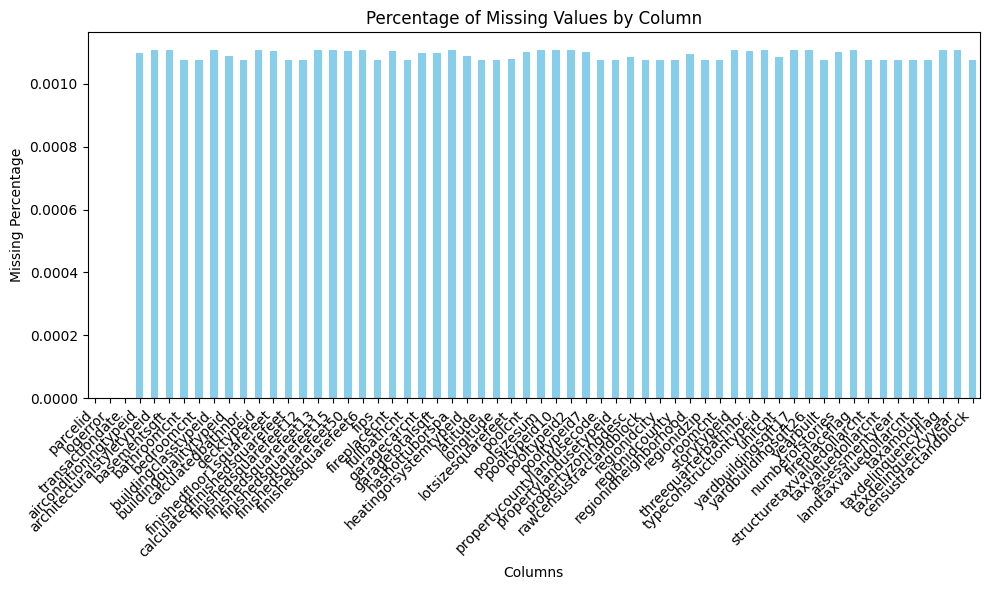

In [13]:
# Let's plot the missing variables
plt.figure(figsize=(10, 6))
missing_data['Missing Percentage'].plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Values by Column')
plt.xlabel('Columns')
plt.ylabel('Missing Percentage')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [14]:
# Separating Datetime variables
zillow['transactiondate']=pd.to_datetime(zillow['transactiondate'])
zillow['month'] = zillow['transactiondate'].dt.month
zillow['year'] = zillow['transactiondate'].dt.year
zillow['month_abbr'] = zillow['month'].apply(lambda x: calendar.month_abbr[x])
zillow.drop('transactiondate', axis=1, inplace=True)

#Finding average monthly error
monthly_error = zillow.groupby(zillow['month'])['logerror'].mean().reset_index()

Our target variable is the logerror column, so let's visualize it.

# Data Visualization

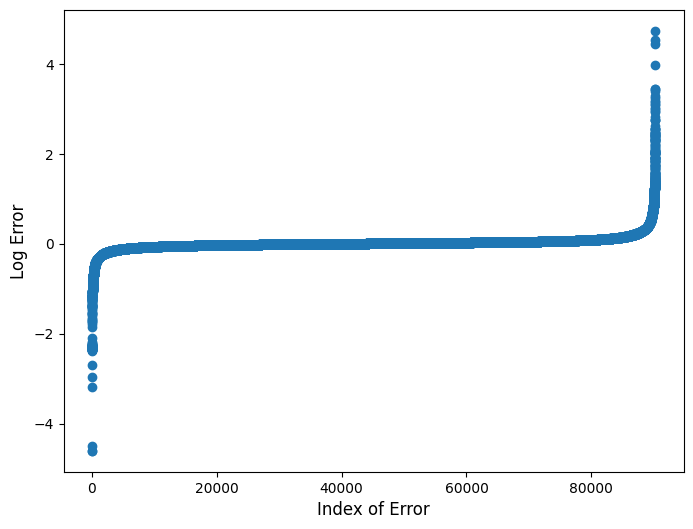

In [15]:
plt.figure(figsize=(8,6))
plt.scatter(range(zillow.shape[0]),np.sort(zillow.logerror.values))
plt.xlabel('Index of Error', fontsize=12)
plt.ylabel('Log Error',fontsize=12)
plt.show()

Some outliers are present at the tail ends, let's try to remove the outliers in a later section. But for now, let's see the distribution of the logerror and the distribution of each transaction month in 2016

<AxesSubplot:title={'center':'Distribution of Transaction Months'}, xlabel='month', ylabel='count'>

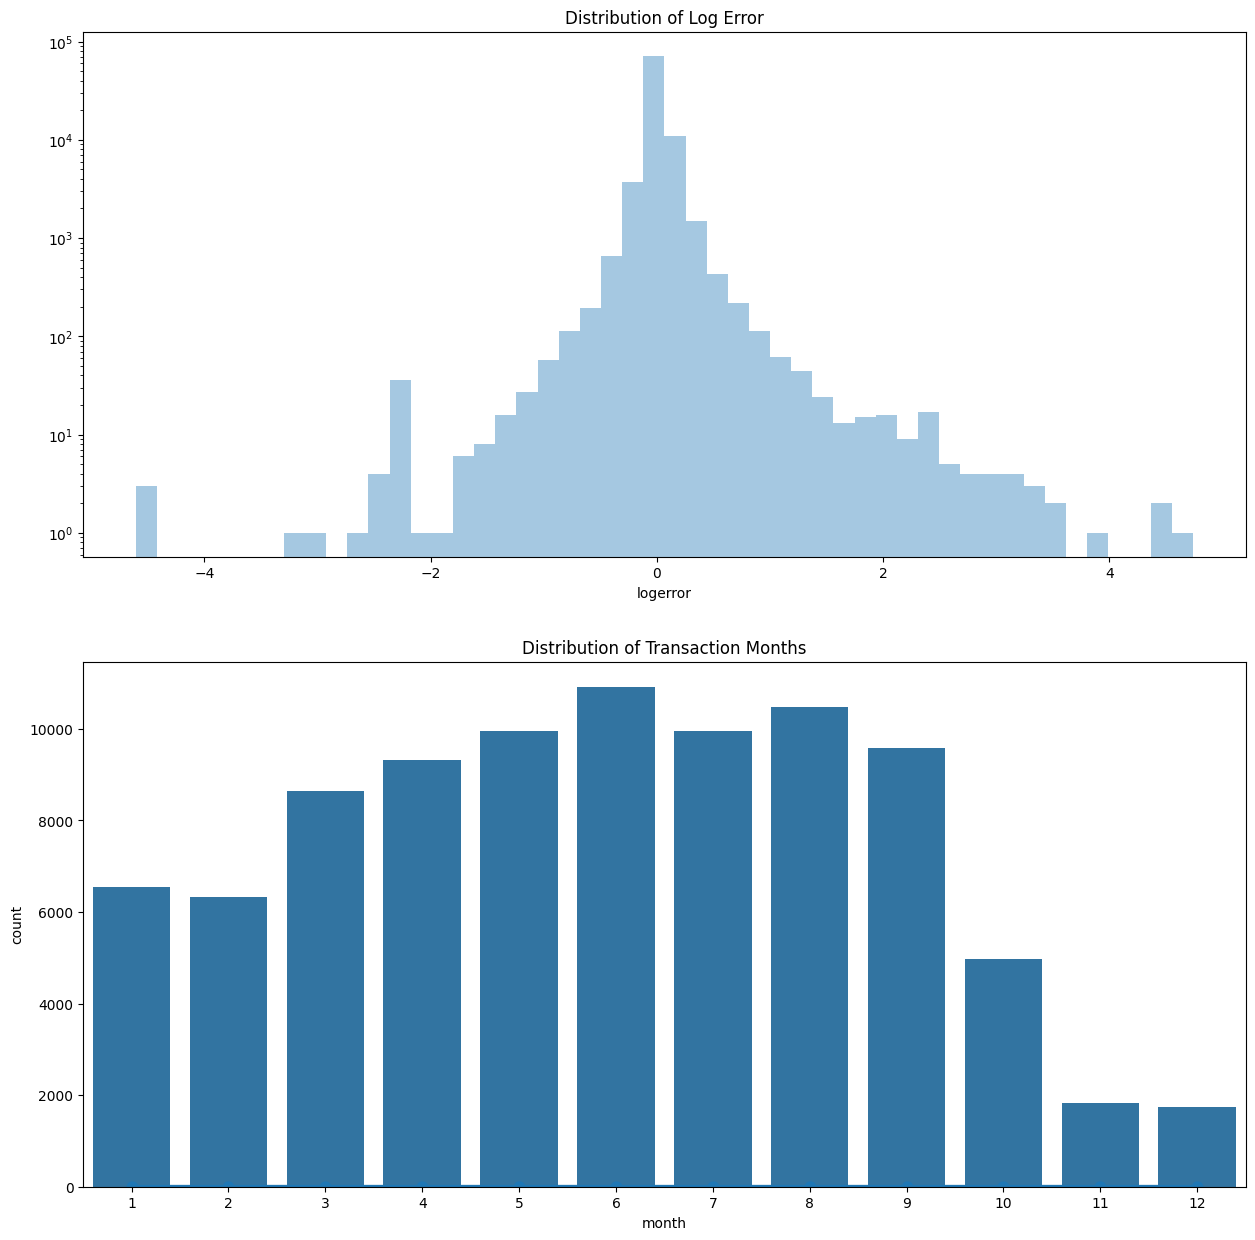

In [16]:
# Exploring Target Variable (logerror)

fig, (ax1, ax2) = plt.subplots(figsize=(15,15),nrows=2)

# Checking Distribution
sns.distplot(zillow['logerror'],kde=False,bins=50,ax=ax1)
ax1.set_yscale('log')
ax1.set_title('Distribution of Log Error')

# Checking monthly sales
ax2.set_title('Distribution of Transaction Months')
sns.countplot(x='month',data=zillow,ax=ax2)
sns.pointplot(x='month',y='logerror',data=monthly_error)


It seems that the data is roughly normally distributed but some outliers do exist as supported by the previous graph. However, when we look at the distribution of transactions per month, we see that the most common months a house is bought/rented is during the Summer (Months 6-8), and the least amount of houses sold seem do be in November and December (Months 11 and 12). For now, let's also take a look at the location of each property and where it possibly might be centralized in

<Figure size 1200x1200 with 0 Axes>

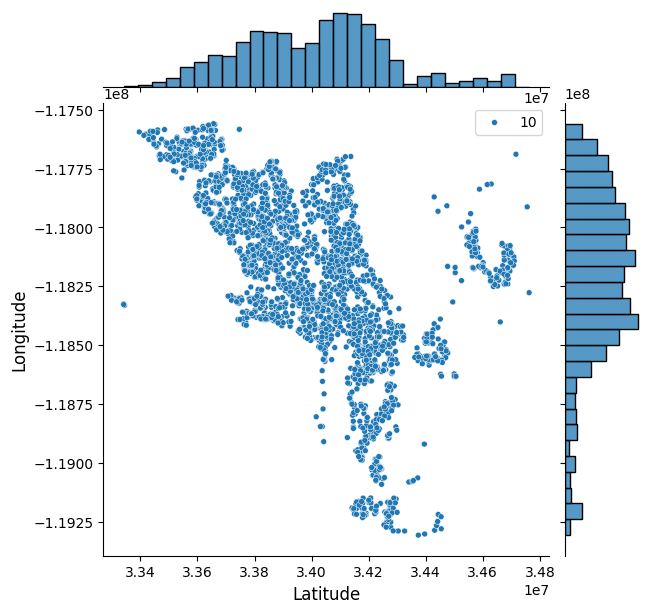

In [17]:
plt.figure(figsize=(12,12))
sns.jointplot(x=zillow.latitude.values, y=zillow.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

This helps us visualize where the general area of the properties dataset is in the Los Angeles, Orange and Ventura counties in California

# Data Cleaning

This is a rather large dataset but only a few variables are important, so we likely won't have to rescale, however, there are some missing data already so let's deal with that now.

## Data Imputation

Looks like majority of our data has the issue of missing more than 90% of our data, so let's impute all of the missing data to contain the mode for categorical data and have it choose between either the mean (for normally distributed columns) or the median (highly-skewed columns)

In [18]:
from scipy.stats import skew

# Function to decide and apply imputation
def impute_missing_values(column):
    if zillow[column].dtype == 'object':
        # Categorical data: Use mode
        mode = zillow[column].mode()[0]
        zillow[column].fillna(mode, inplace=True)
    else:
        # Numeric data: Decide between mean and median based on skewness
        if skew(zillow[column].dropna()) > 1 or skew(zillow[column].dropna()) < -1:
            # Highly skewed data: Use median
            median = zillow[column].median()
            zillow[column].fillna(median, inplace=True)
        else:
            # Normally distributed data: Use mean
            mean = zillow[column].mean()
            zillow[column].fillna(mean, inplace=True)

In [19]:
for col in zillow.columns:
    if zillow[col].isnull().sum() > 0:
        impute_missing_values(col)

# Recheck missingness
print("Missing Data After Imputation:\n",zillow.isnull().sum())

Missing Data After Imputation:
 parcelid                    0
logerror                    0
airconditioningtypeid       0
architecturalstyletypeid    0
basementsqft                0
                           ..
taxdelinquencyyear          0
censustractandblock         0
month                       0
year                        0
month_abbr                  0
Length: 62, dtype: int64


### Now let's visualize our dataset after all of the cleaning and see if there is anything else to do.

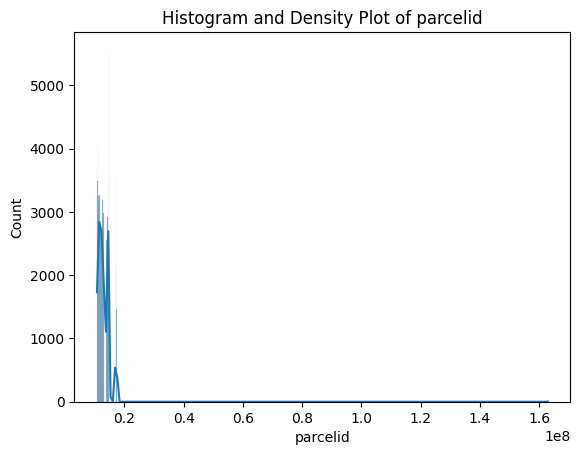

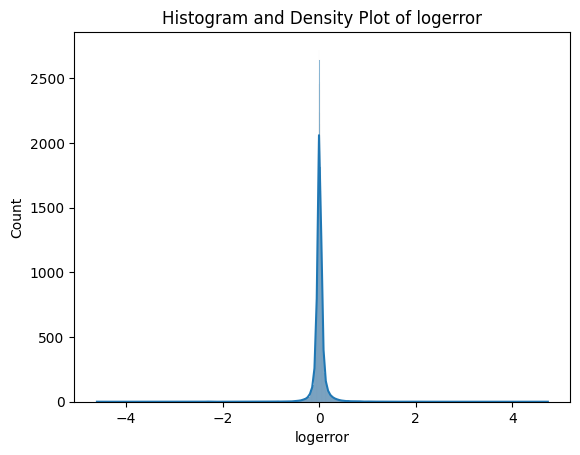

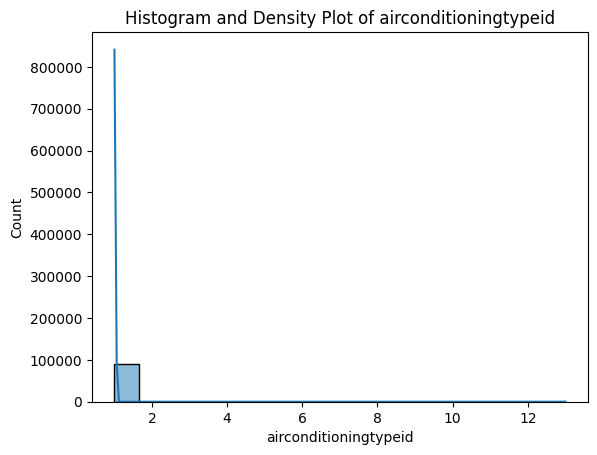

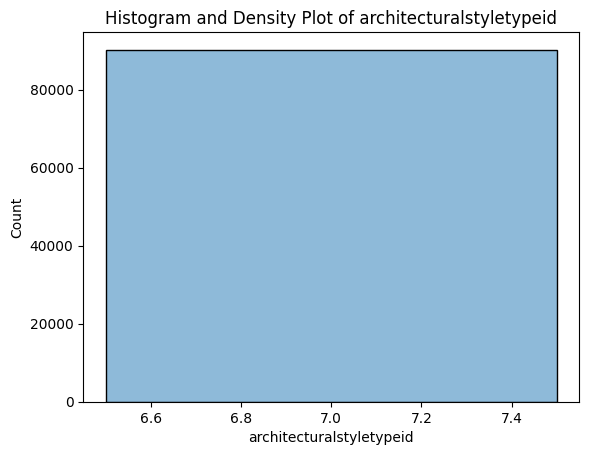

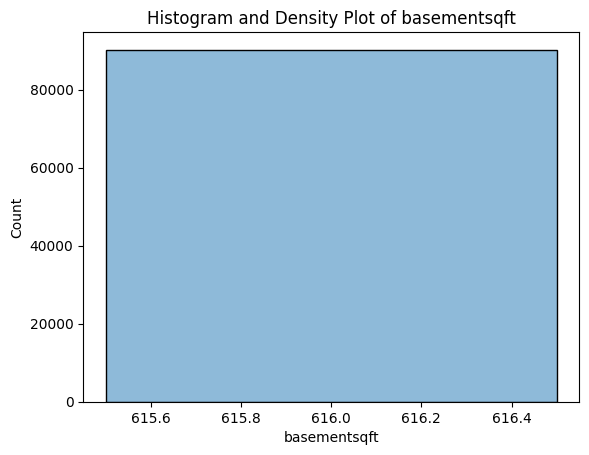

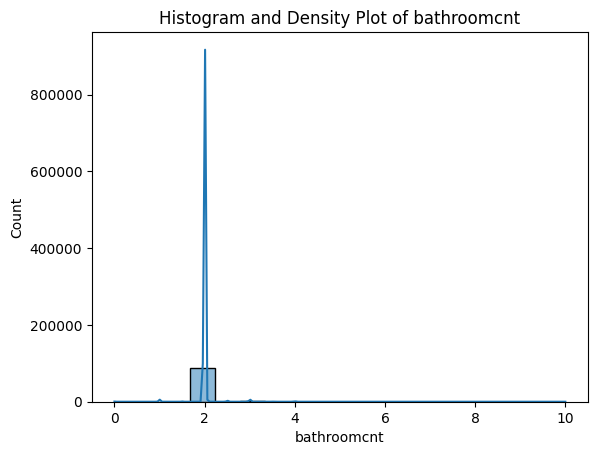

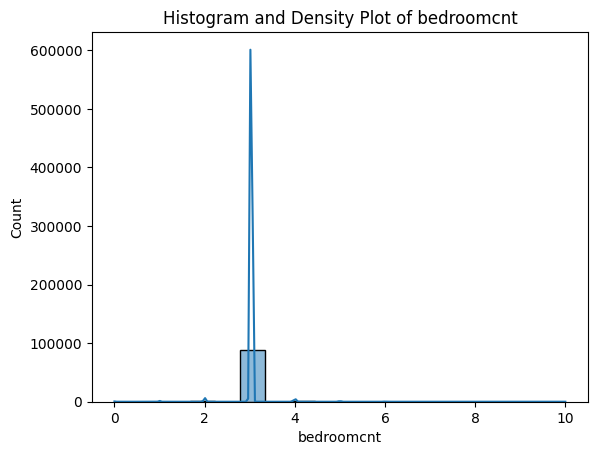

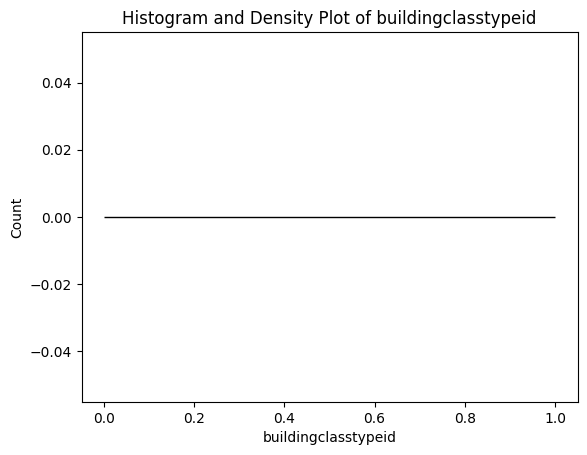

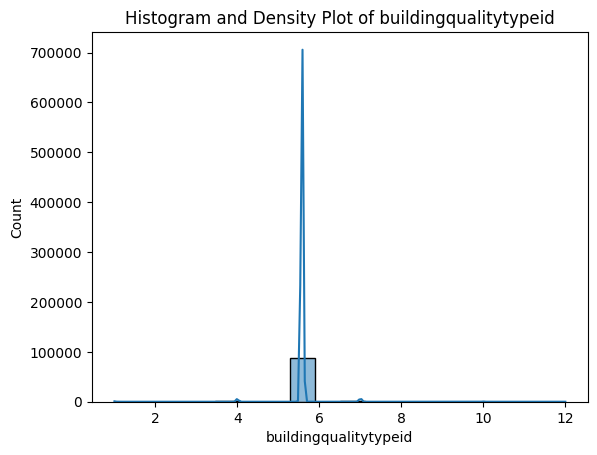

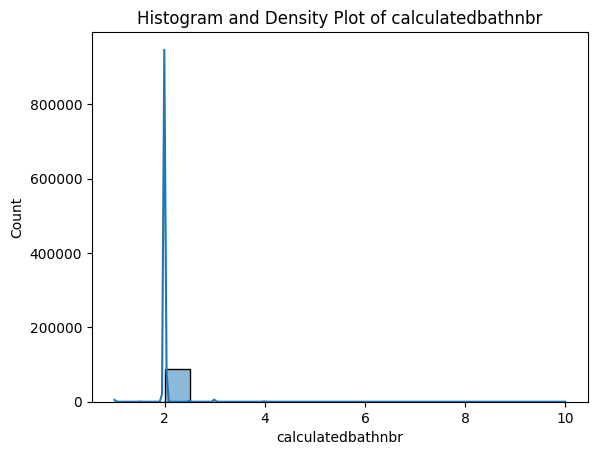

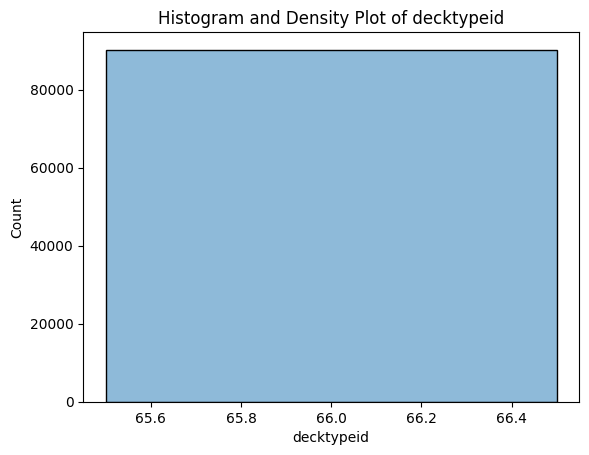

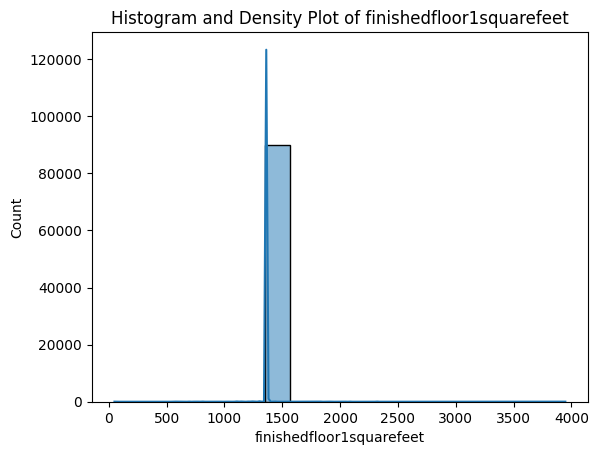

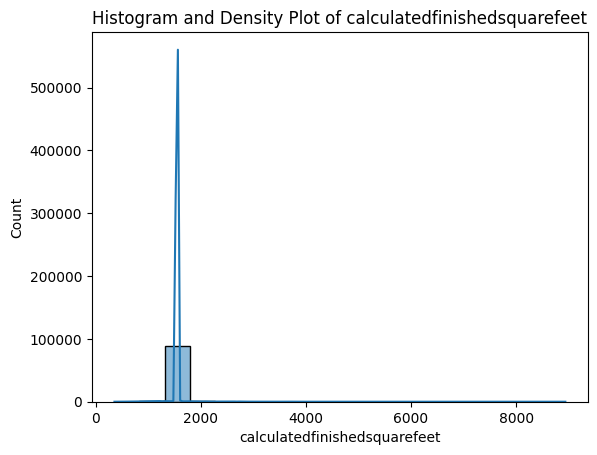

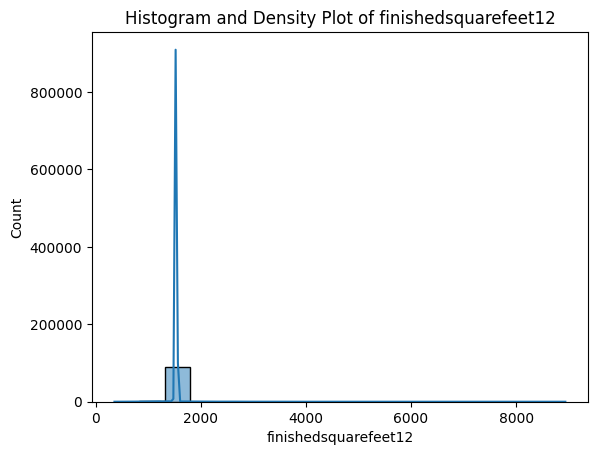

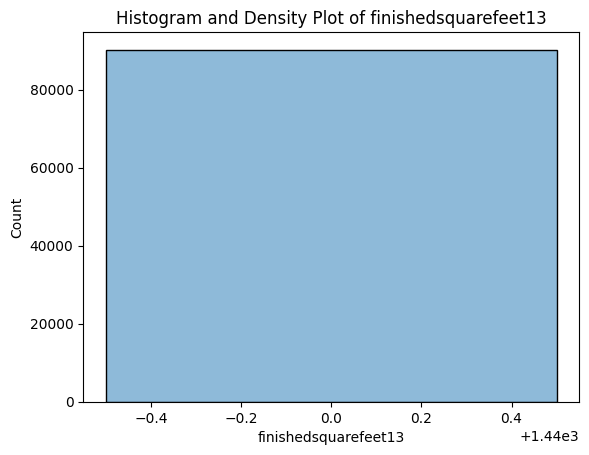

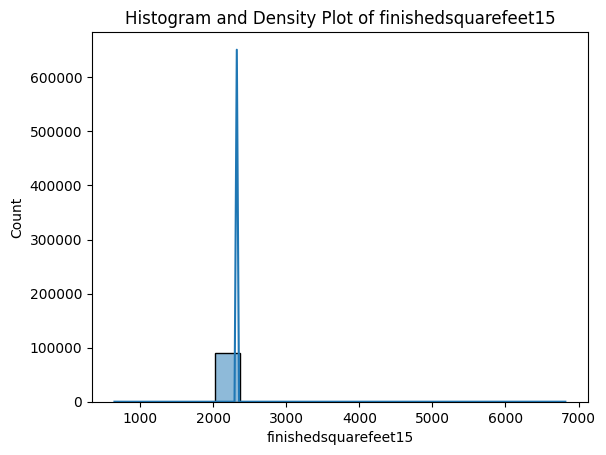

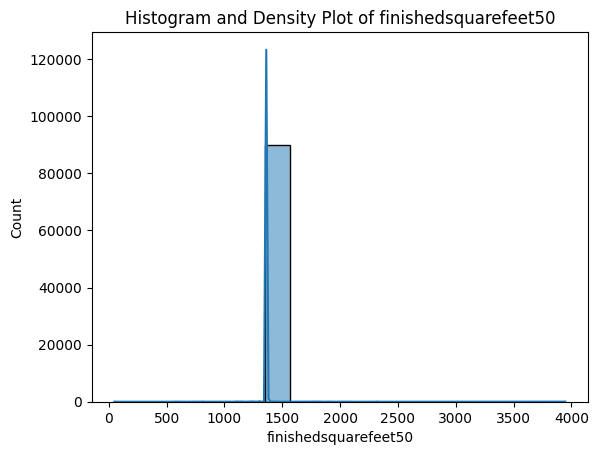

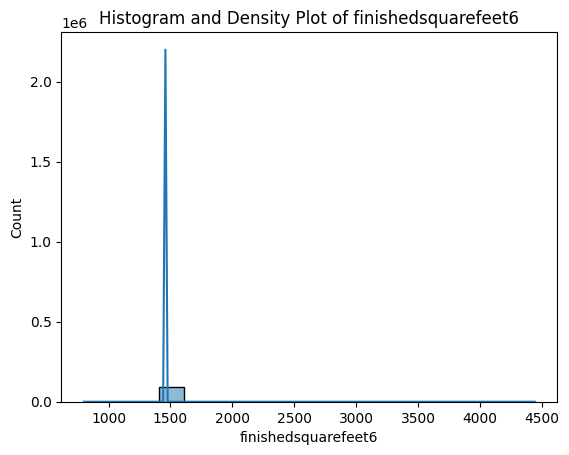

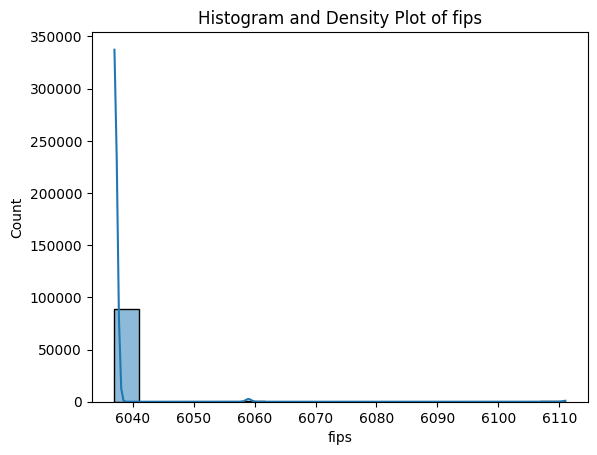

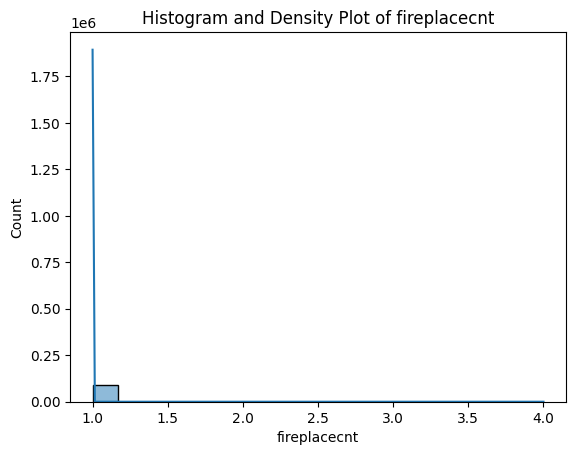

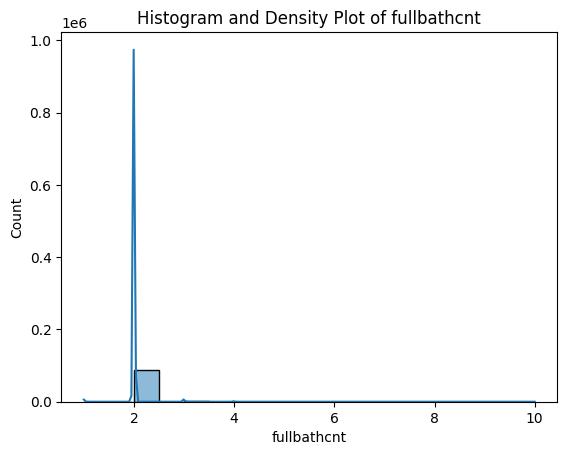

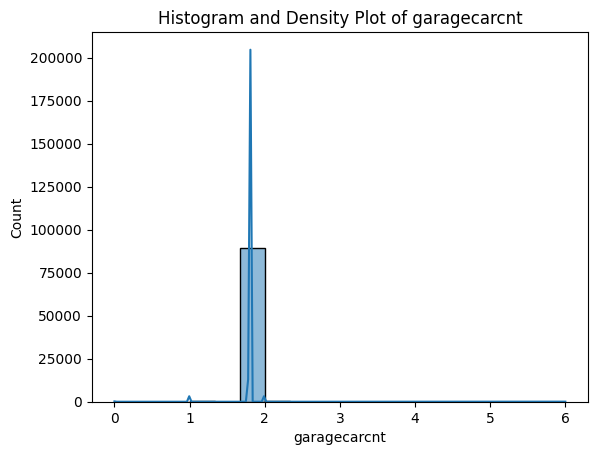

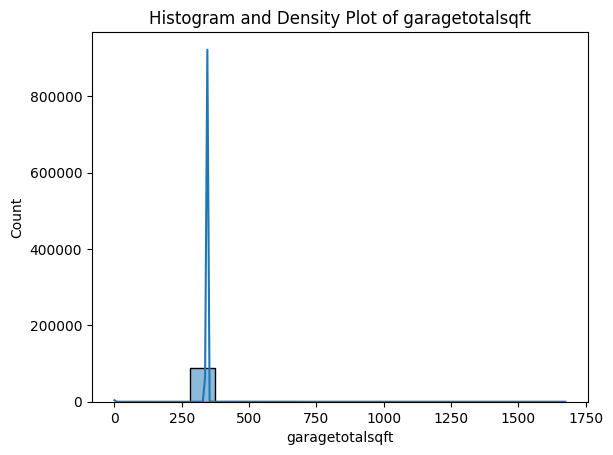

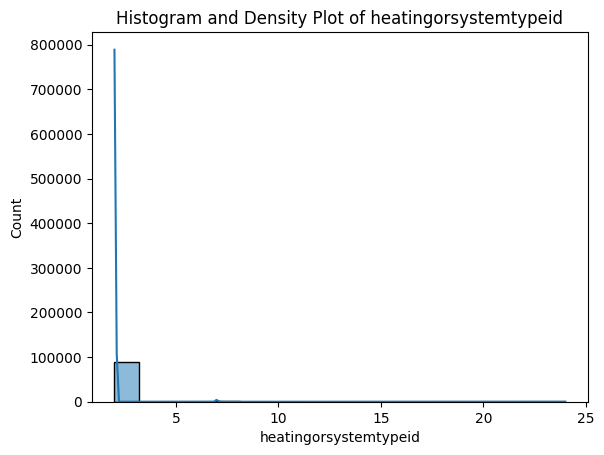

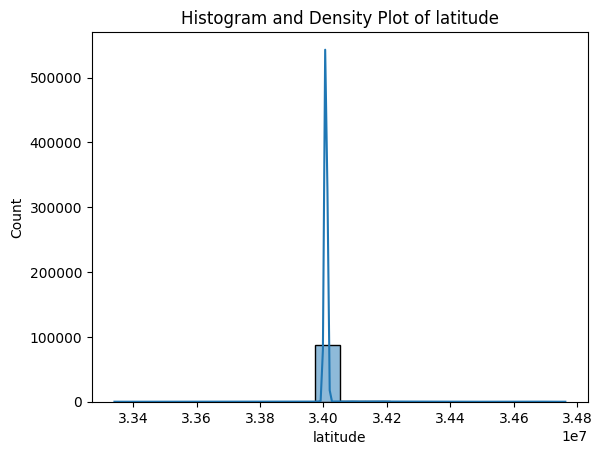

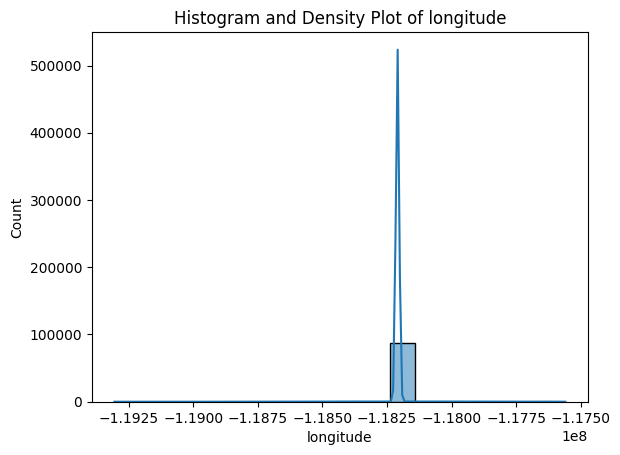

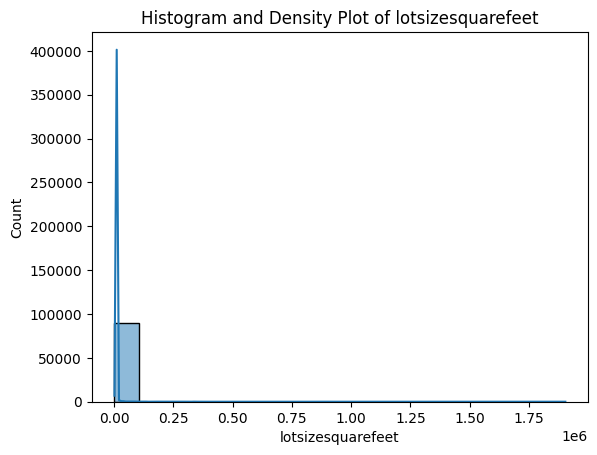

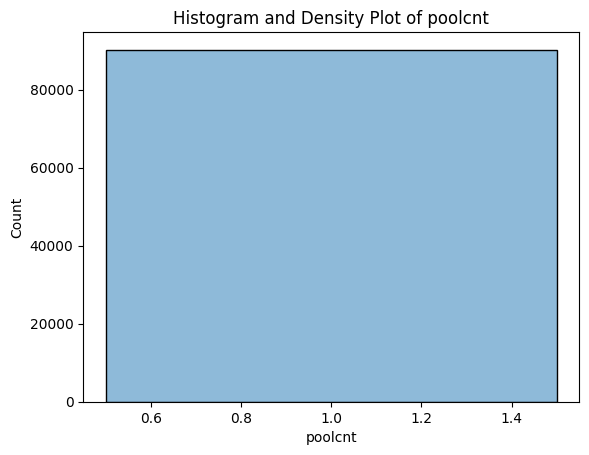

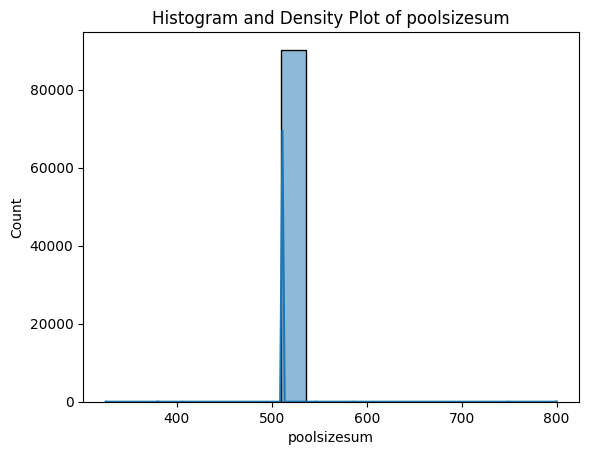

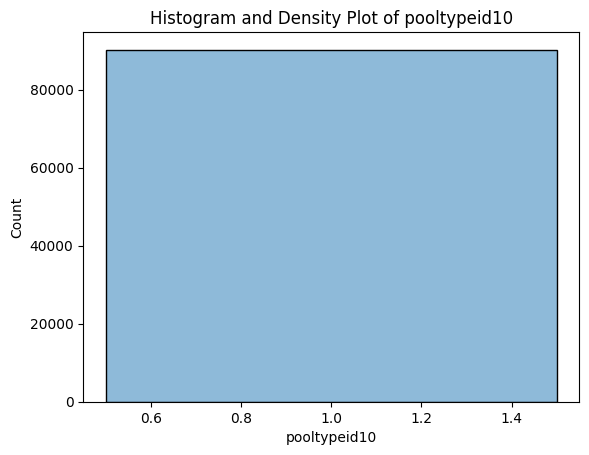

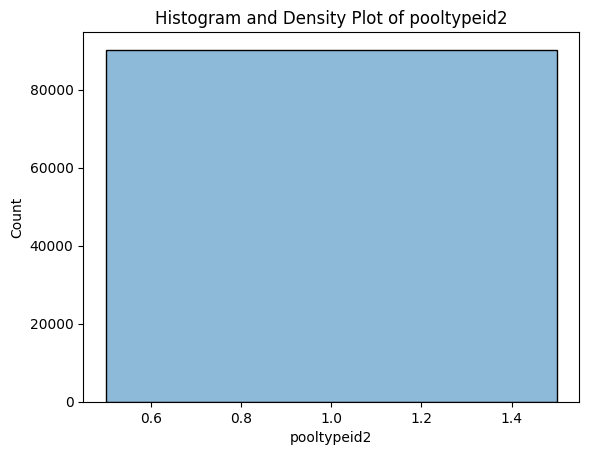

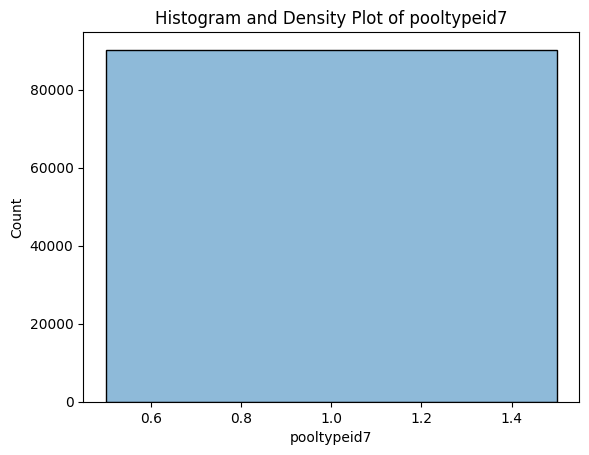

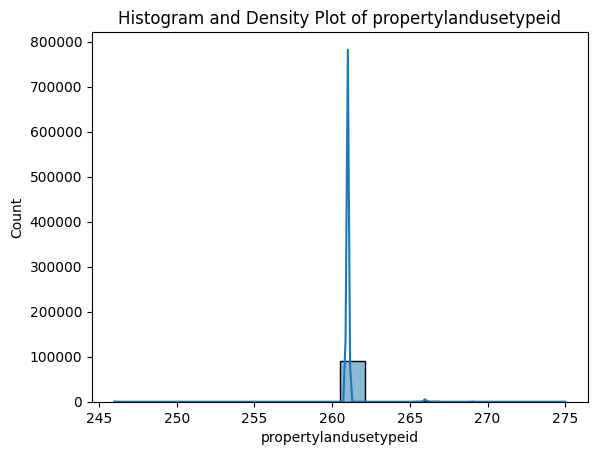

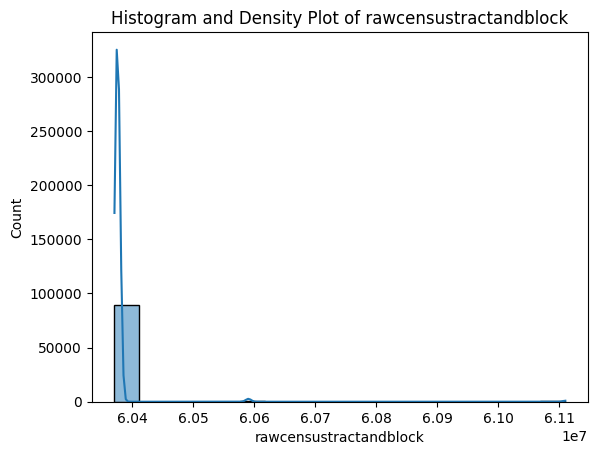

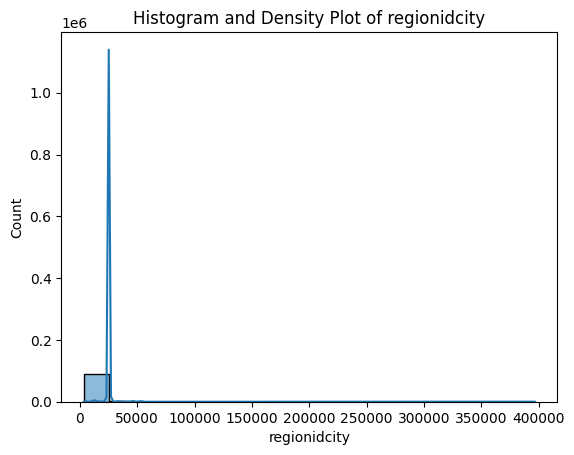

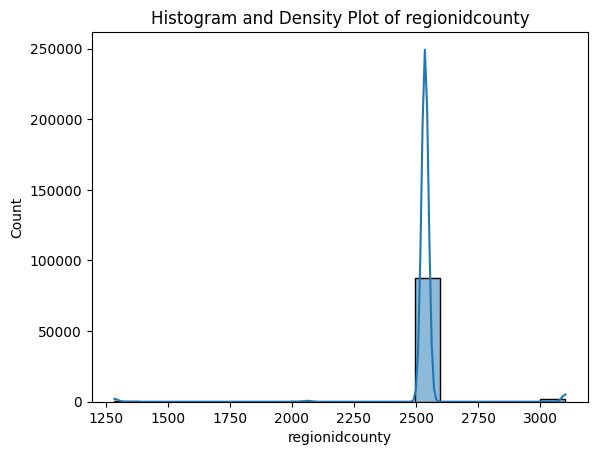

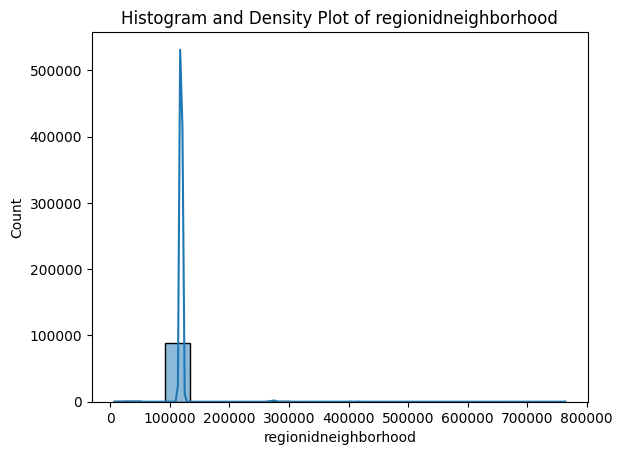

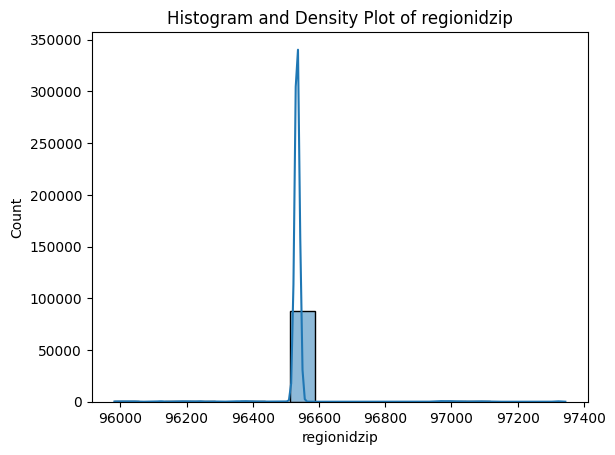

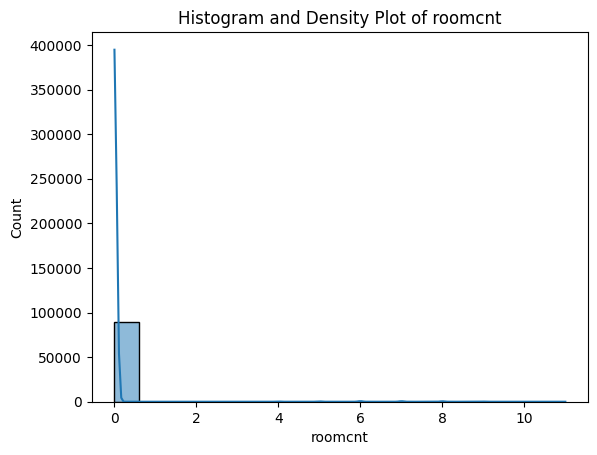

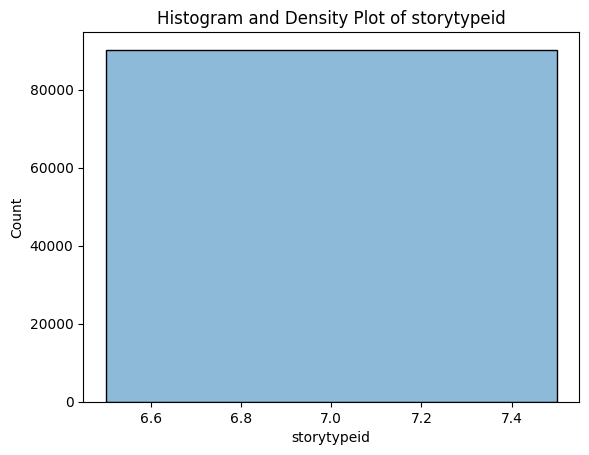

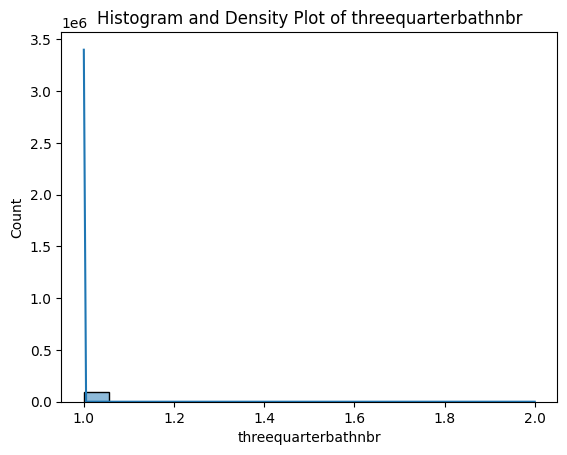

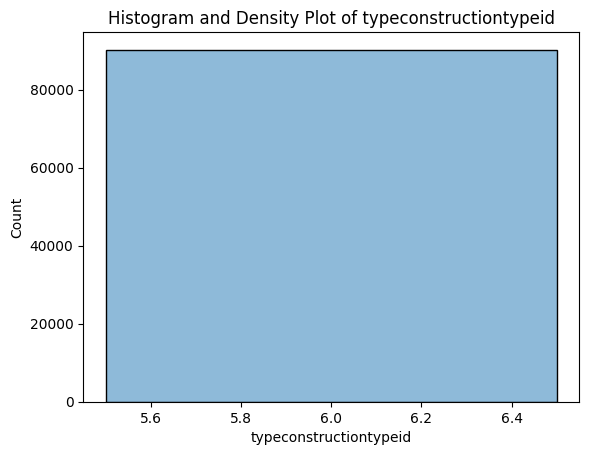

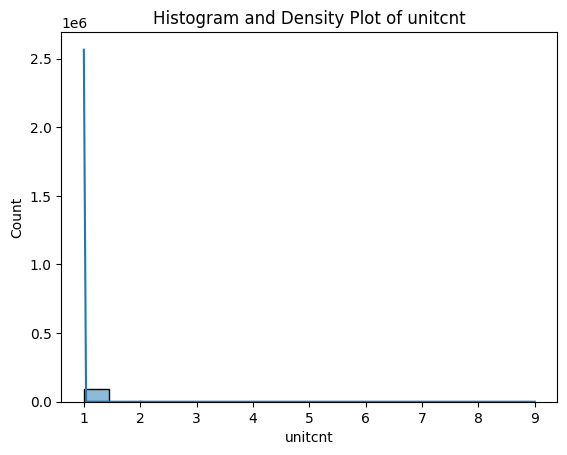

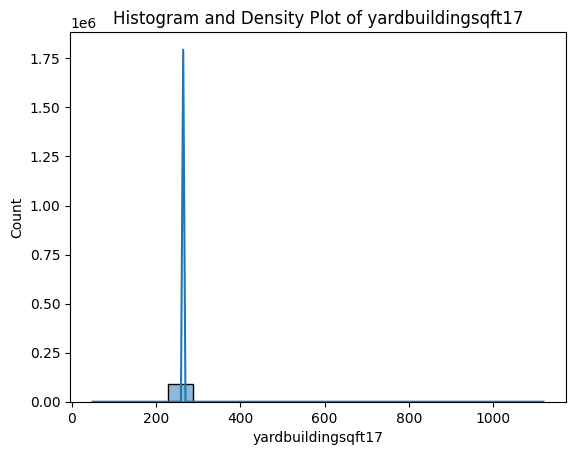

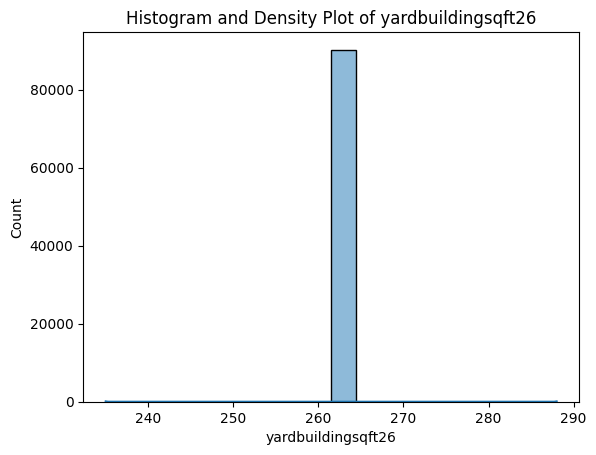

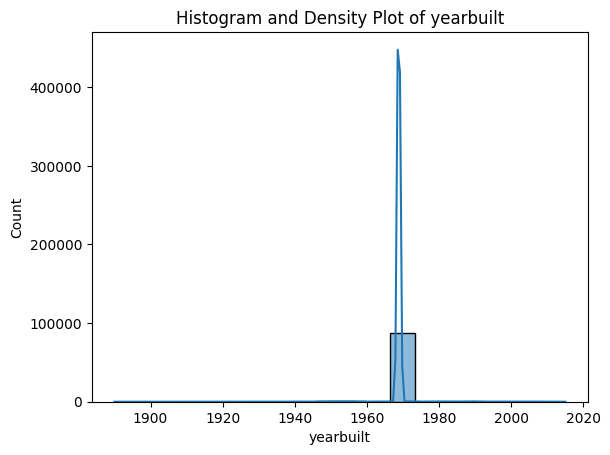

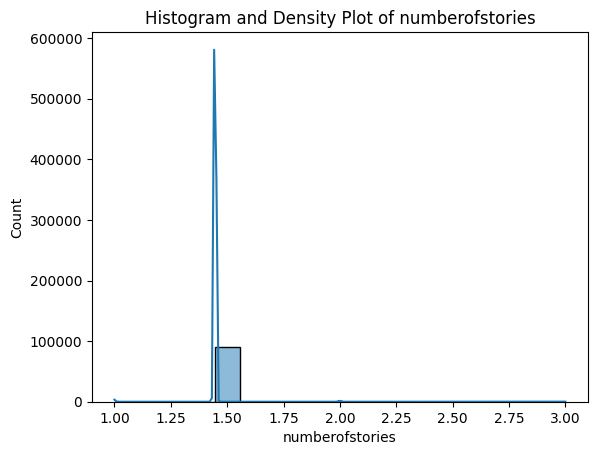

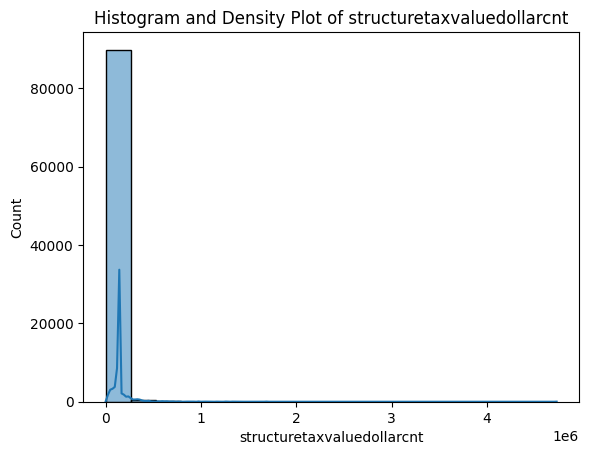

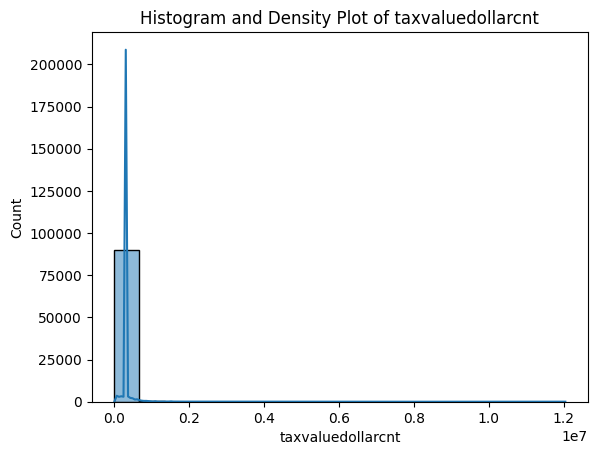

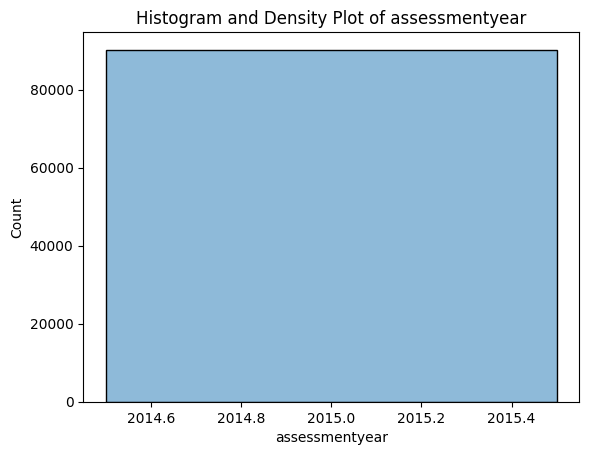

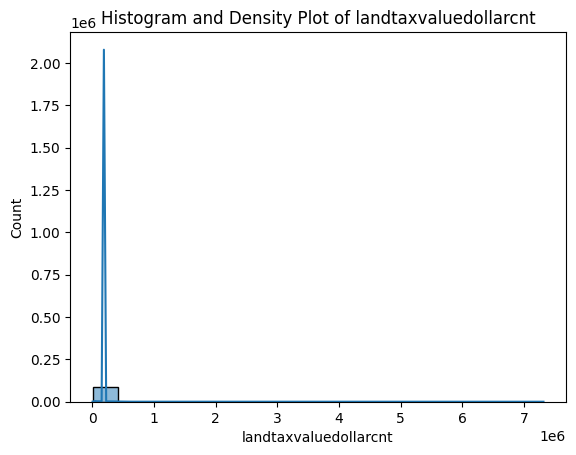

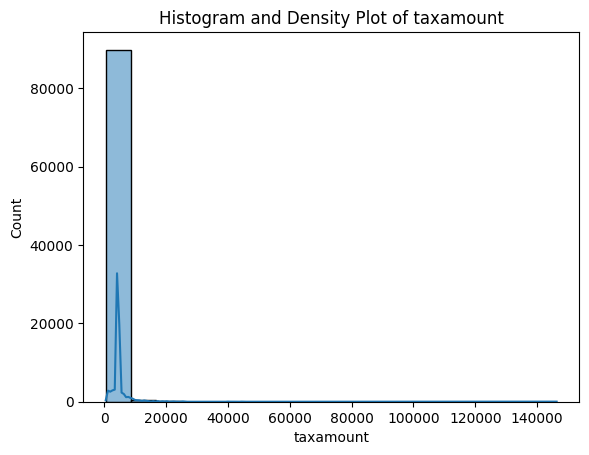

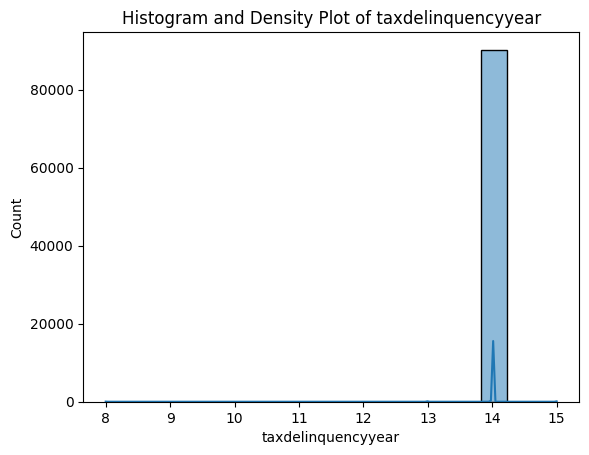

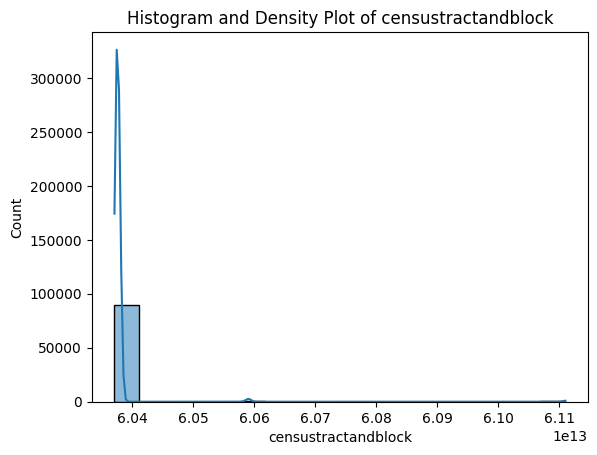

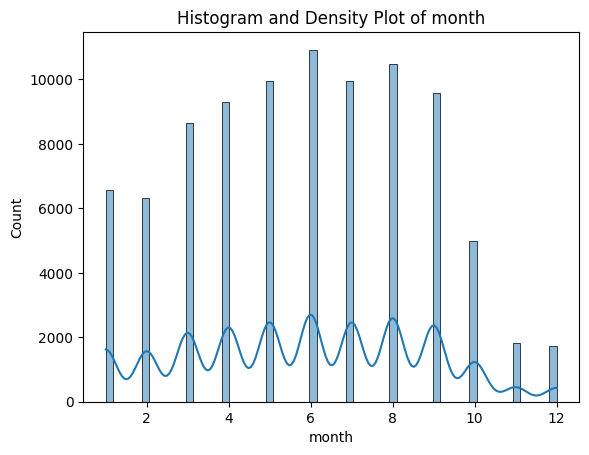

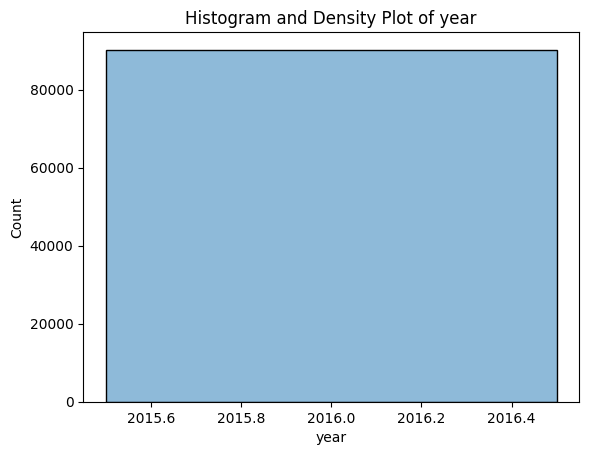

In [20]:
for col in zillow.select_dtypes(include=['number']).columns:
    sns.histplot(zillow[col], kde=True)
    plt.title(f'Histogram and Density Plot of {col}')
    plt.show()

### Conclusions After Imputation

- It seems now that most of the distributions for the dataset is approximately normal, however some of the plots are boxes (mainly the categories with zip codes and ids) so we can ignore them.
- Nice! We no longer have any missing values left, now we can proceed to formulating what Machine Learning algorithm will fit best for our dataset

# Machine Learning

## Problem Formulation

Before we start working on our ML algorithm, let's see what features are the most important by starting with ten of the variables

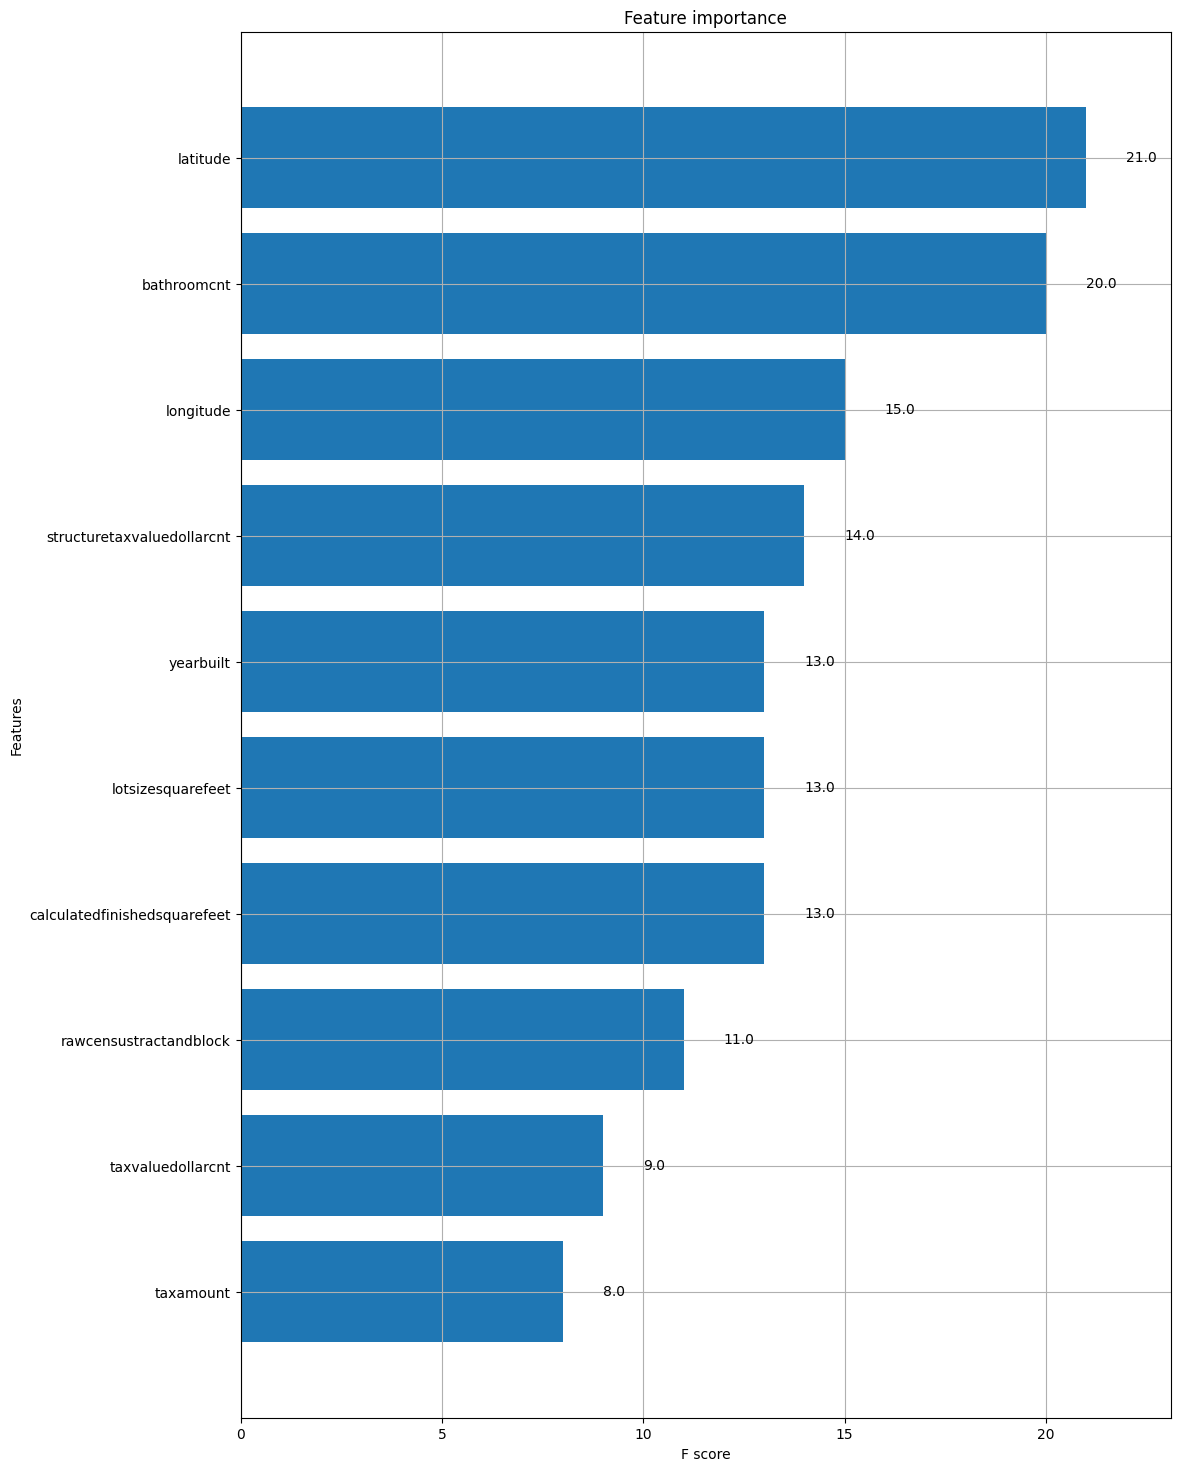

In [29]:
# Let's visualize our feature importances
fig, ax = plt.subplots(figsize = (12,18))
xgb.plot_importance(model, max_num_features = 10, height = 0.8, ax = ax)
plt.show()

It seems our most important features include 'latitude', 'bathroomcnt', 'longitude', 'structuretaxdollarvaluecnt'. Any feature that is less than 13.0 for the F-score, we can assume play no part in the training of the model.

## Converting Categorical Variables

Since we have a a few categorical values, lets use LabelEncoder, but let's discuss what LabelEncoding does overall:
- Since categorical data is typically hard to predict data on, the best way to do so is to convert them into numerical inputs so that the algorithm can easily read over the data and create predictions.

In [21]:
from sklearn.preprocessing import LabelEncoder

for c in props.columns: # Converts all categorical values to numerical values via Label Encoding
    props[c]=props[c].fillna(-1)
    if props[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(props[c].values))
        props[c] = lbl.transform(list(props[c].values))

train_df = train.merge(props, how='left', on='parcelid') #Merged the old dataset with the converted properties set

### Train-Test Split

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [23]:
x_train = train_df.drop(['parcelid', 'logerror','transactiondate'], axis=1)
x_test = props.drop(['parcelid'], axis=1)
# printing out the shape        
print('Shape of train dataset: {}\nShape of test dataset: {}'.format(x_train.shape, x_test.shape))

# taking out potential outliers to fit our model better
train_df=train_df[ train_df.logerror > -0.4 ]
train_df=train_df[ train_df.logerror < 0.42 ]
x_train=train_df.drop(['parcelid', 'logerror','transactiondate'], axis=1)
y_train = train_df["logerror"].values.astype(np.float32)
y_mean = np.mean(y_train)

Shape of train dataset: (90275, 57)
Shape of test dataset: (90274, 57)


## ML Algorithm: XGBoost

For our algorithm, we will use XGBoost. But why?
- XGBoosting creates several miniature sample datasets that we can train upon
- Then we can check and see what features are important and not important
- Afterwards, we can create a cross-validation set by using k-fold validation which creates five different sets which trains on four sets and tests on one set across the board five times.
- Then afterwards, we can check how it does after a certain number of boosting rounds to see if the mean absolute error (MAE) is relatively similar to the training set.

In [24]:
import xgboost as xgb
# Parameters for XG Boosting
xgb_params = {
    'eta': 0.033,
    'max_depth': 6,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'base_score': y_mean,
    'silent': 1
}

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

In [25]:
# Creating Cross-Validation Set
cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   nfold=5,
                   num_boost_round=500,
                   early_stopping_rounds=5,
                   verbose_eval=10, 
                   show_stdv=False
                  )

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

[0]	train-mae:0.05331	test-mae:0.05331
[10]	train-mae:0.05328	test-mae:0.05331
[11]	train-mae:0.05327	test-mae:0.05331
8


It looks like our MAE score is roughly average at the 0.05327 to 0.0533 range, which is good!

## Training Model on XGBoost

In [26]:
# training our model
model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=num_boost_rounds)
pred = model.predict(dtest)
y_pred=[]

# Printing out our MAE scores for the train and test sets
for i,predict in enumerate(pred):
    y_pred.append(str(round(predict,10)))
y_pred=np.array(y_pred)

In [27]:
# Now that we have predicted our outputs, let's print them out into a .csv file
output = pd.DataFrame({'ParcelId': props['parcelid'].astype(np.int32),
        '201610': y_pred, '201611': y_pred, '201612': y_pred,
        '201710': y_pred, '201711': y_pred, '201712': y_pred})

# set col 'ParceID' to first col
cols = output.columns.tolist()
cols = cols[-0:]
output = output[cols]

output.to_csv('sub.csv',index=False)

# Model Output

In [28]:
output_read = pd.read_csv('sub.csv')
output_read.head(5)

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0.011052,0.011052,0.011052,0.011052,0.011052,0.011052
1,10759547,0.009942,0.009942,0.009942,0.009942,0.009942,0.009942
2,10843547,-0.007624,-0.007624,-0.007624,-0.007624,-0.007624,-0.007624
3,10859147,0.008483,0.008483,0.008483,0.008483,0.008483,0.008483
4,10879947,0.004693,0.004693,0.004693,0.004693,0.004693,0.004693


### Model Comparison
- Our MAE Metric is roughly around the 0.05327 ~ 0.05331
- The Kaggle score that we recieved is around 0.0521

# Conclusion

Achieving an average Mean Absolute Error (MAE) score of 0.5331 in the Zillow Price Kaggle Challenge reflects solid performance in predicting log error differences. This score indicates that, on average, the model's predictions deviate by approximately 0.5331 from the actual log error differences. By comparing this score with others and evaluating performance on different subsets of the data, strengths and areas for improvement can be identified. Lower log error differences suggest potential enhancements to Zillow's property valuation algorithm, which could lead to improved user satisfaction and platform competitiveness. Future work may involve exploring alternative modeling techniques or incorporating additional data sources to further refine predictive accuracy and address any remaining challenges.